In [1]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras

2025-10-30 09:33:12.179646: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Paths
train_dir = "Data/train"
test_dir = "Data/test"
classes = ["Abnormal_Heartbeat", "Myocardial_Infarction", "History_Myocardial_Infarction", "Normal"]

In [3]:
# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 256, 512
BATCH_SIZE = 4  # small batch due to large images

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # important for correct label ordering
)

Found 2572 images belonging to 4 classes.
Found 451 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


In [4]:
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Stage 1: Feature extraction
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(classes), activation='softmax')(x)

/tmp/ipykernel_3075389/341446833.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False,
2025-10-30 09:33:23.527886: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 256,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 256,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 256,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 256,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 256,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 256,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 256,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 256,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 256,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 256,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 256,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 257,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 128,   │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 128,   │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 128,   │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 128,   │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [12]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "mobilenetv2_best_stage1.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

print("\n🔹 Training Stage 1: Feature Extraction...")
history_stage1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint, lr_reduction]
)


🔹 Training Stage 1: Feature Extraction...
Epoch 1/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4724 - loss: 1.1921
Epoch 1: val_loss improved from None to 0.82261, saving model to mobilenetv2_best_stage1.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 184s 274ms/step - accuracy: 0.5385 - loss: 1.0515 - val_accuracy: 0.6630 - val_loss: 0.8226 - learning_rate: 0.0010
Epoch 2/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.6061 - loss: 0.9099
Epoch 2: val_loss improved from 0.82261 to 0.79265, saving model to mobilenetv2_best_stage1.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 170s 264ms/step - accuracy: 0.6201 - loss: 0.8798 - val_accuracy: 0.6652 - val_loss: 0.7926 - learning_rate: 0.0010
Epoch 3/50
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.6584 - loss: 0.8012
Epoch 3: val_loss did not improve from 0.79265
643/643 ━━━━━━━━━━━━━━━━━━━━ 189s 293ms/step - accuracy: 0.6625 - loss: 0.7965 - val_accuracy: 0.6608 - val_loss: 0.8164 - learning_rate: 0.0010
Epoch 4/50
643/643

In [13]:
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Recompile with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_fine = ModelCheckpoint(
    "mobilenetv2_best_finetuned.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("\n🔹 Training Stage 2: Fine-Tuning...")
history_stage2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint_fine, lr_reduction]
)


🔹 Training Stage 2: Fine-Tuning...
Epoch 1/20


2025-10-28 11:44:19.701141: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-28 11:44:19.847518: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-28 11:44:19.971631: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-28 11:44:20.417181: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-28 11:44:20.540037: E external/local_xla/xla/stream_

643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.4192 - loss: 12.6404
Epoch 1: val_loss improved from None to 4.84354, saving model to mobilenetv2_best_finetuned.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 194s 269ms/step - accuracy: 0.4736 - loss: 9.6910 - val_accuracy: 0.5698 - val_loss: 4.8435 - learning_rate: 1.0000e-05
Epoch 2/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5466 - loss: 5.0576
Epoch 2: val_loss improved from 4.84354 to 4.61381, saving model to mobilenetv2_best_finetuned.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 164s 255ms/step - accuracy: 0.5607 - loss: 4.3292 - val_accuracy: 0.5743 - val_loss: 4.6138 - learning_rate: 1.0000e-05
Epoch 3/20
643/643 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.6215 - loss: 2.5420
Epoch 3: val_loss improved from 4.61381 to 4.35988, saving model to mobilenetv2_best_finetuned.keras
643/643 ━━━━━━━━━━━━━━━━━━━━ 161s 250ms/step - accuracy: 0.6166 - loss: 2.2310 - val_accuracy: 0.5965 - val_loss: 4.3599 - learning_rate: 1.0000e-05

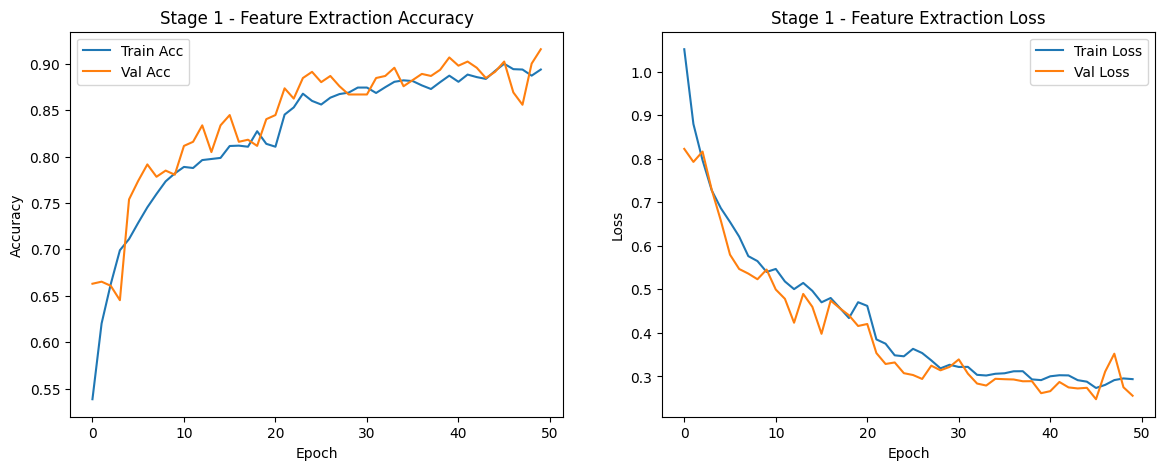

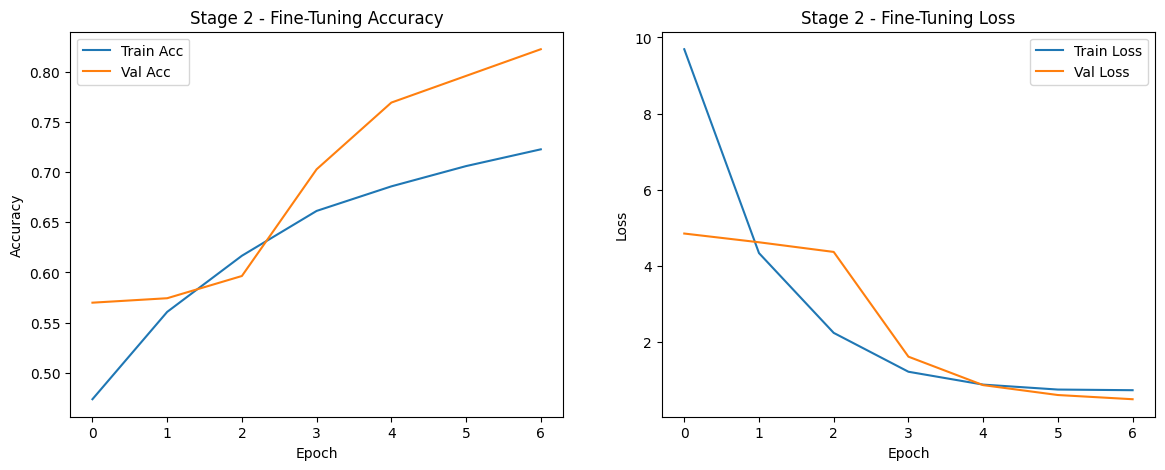

In [14]:
def plot_history(hist, title):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_stage1, "Stage 1 - Feature Extraction")
plot_history(history_stage2, "Stage 2 - Fine-Tuning")


In [6]:
print("\n🔹 Evaluating on Test Set...")
model = keras.models.load_model("mobilenetv2_best_stage1.keras")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


🔹 Evaluating on Test Set...


/home/calviem/CSSE416/Homework/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-30 09:33:35.490063: I external/local_xla/xla/service/service.cc:163] XLA service 0x7fb0fc0f9b00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-10-30 09:33:35.490126: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Host, Default Version
2025-10-30 09:33:35.719391: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761831217.404472 3076812 device_compiler.h:196] Compiled cluster using XLA!  This line

232/232 ━━━━━━━━━━━━━━━━━━━━ 77s 308ms/step - accuracy: 0.7759 - loss: 0.6117
✅ Test Accuracy: 0.7759 | Test Loss: 0.6117


232/232 ━━━━━━━━━━━━━━━━━━━━ 72s 300ms/step


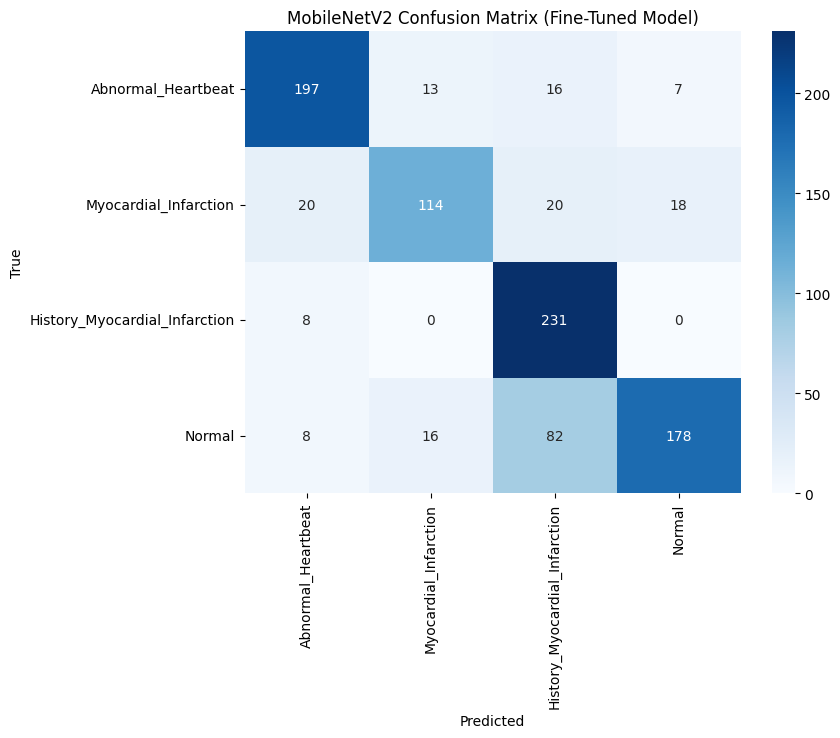

In [7]:
preds = model.predict(test_generator, steps=len(test_generator), verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_generator.classes

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MobileNetV2 Confusion Matrix (Fine-Tuned Model)")
plt.show()

In [8]:
report = classification_report(true_labels, pred_labels, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
Abnormal_Heartbeat,0.845494,0.845494,0.845494,233.000000
Myocardial_Infarction,0.797203,0.662791,0.723810,172.000000
History_Myocardial_Infarction,0.661891,0.966527,0.785714,239.000000
Normal,0.876847,0.626761,0.731006,284.000000
accuracy,0.775862,0.775862,0.775862,0.775862
macro avg,0.795359,0.775393,0.771506,928.000000
weighted avg,0.798853,0.775862,0.772507,928.000000
